# Testbed for TF2 Optimizers

Inspired by machinelearningmastery.com [blog posting](https://machinelearningmastery.com/gradient-descent-optimization-with-nadam-from-scratch/)

Requires TF 2.x

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import tensorflow as tf

In [71]:
a = tf.range(-1, 1, 0.1, dtype=tf.float32)
b = tf.range(-1, 1, 0.1, dtype=tf.float32)

In [72]:
t_list = tf.meshgrid(a, b, indexing='ij')
t = tf.stack(t_list, axis=-1)
t.shape

TensorShape([20, 20, 2])

In [261]:
def objective_function(t):
    return tf.reduce_sum((t * [1, 1])**2, axis=-1)

results = objective_function(t)

In [262]:
results.shape

TensorShape([20, 20])

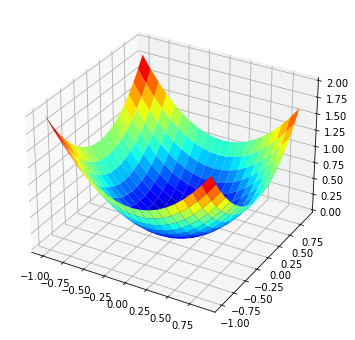

In [263]:

# create a surface plot with the jet color scheme
figure = plt.figure(figsize=(6,6))
axis = figure.gca(projection='3d')
axis.plot_surface(t_list[0], t_list[1], 
                  results.numpy(), cmap='jet')
# show the plot
plt.show()

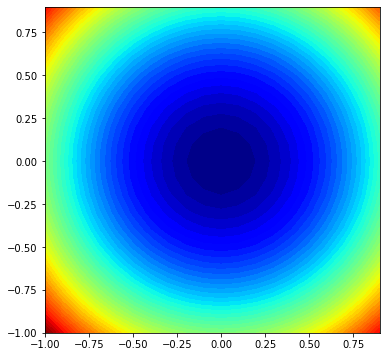

In [264]:
# create a filled contour plot with 50 levels and jet color scheme
figure = plt.figure(figsize=(6,6))
plt.contourf(t_list[0], t_list[1], results, levels=50, cmap='jet')
# show the plot
plt.show()

In [265]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [266]:
x = tf.Variable([.7, .8], dtype=tf.float32)
objective_function(x)

<tf.Tensor: shape=(), dtype=float32, numpy=1.13>

In [267]:
solutions = []
for _ in range(1000):

    #calculate loss function 
    with tf.GradientTape() as tape:
        loss = objective_function(x)

    # calculate gradient
    var_list = [x]
    grad = tape.gradient(loss, var_list)
    
    # update solution using the calculated gradient
    optimizer.apply_gradients(zip(grad, var_list))
    solutions.append(x.numpy())
    if len(solutions) > 10:
        if np.abs(objective_function(solutions[-1]) - objective_function(solutions[-2])) < 1e-7:
            break
    
# consolidate the trajectory the optimizer
solution_path = np.stack(solutions)

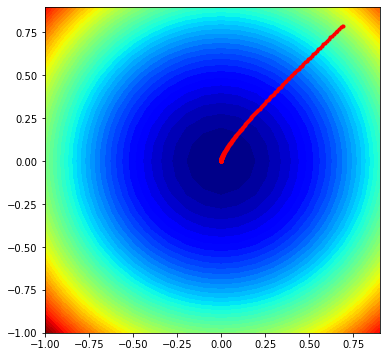

In [268]:
# create a filled contour plot with 50 levels and jet color scheme
figure = plt.figure(figsize=(6,6))
plt.contourf(t_list[0], t_list[1], results, levels=50, cmap='jet')
plt.plot(solution_path[:,0], solution_path[:,1], '.-', color='r')
# show the plot
plt.show()

In [269]:
print(objective_function(solution_path[-1]), solution_path[-1])

tf.Tensor(5.396965360676943e-07, shape=(), dtype=float64) [-0.0002534   0.00068955]


In [270]:
print(len(solution_path))

197
